In [108]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

from sklearn.decomposition import PCA

import net_helpers
import mpn_tasks
import helper
import mpn
import clustering

In [109]:
basepath = "./pretraining"
stage1_name1 = "fdanti"
stage1_name2 = "delaygo"
final_name = "delayanti"

seed = 71
filepath = f"output_{stage1_name1}_{stage1_name2}_seed{seed}_+hidden300+batch128+stimulus"
parampath = f"param_{stage1_name1}_{stage1_name2}_seed{seed}_+hidden300+batch128+stimulus"

stage1_output_path = f"{basepath}/{filepath}_stage1.npz"
stage2_output_path = f"{basepath}/{filepath}_stage2.npz"
final_param_path = f"{basepath}/{parampath}_result.npz"

stage1_output = np.load(stage1_output_path, allow_pickle=True)
stage2_output = np.load(stage2_output_path, allow_pickle=True)
final_param = np.load(final_param_path, allow_pickle=True)

In [110]:
all_rule_info = final_param['rules_epochs']

In [111]:
final_param.files

['rules_epochs',
 'rules_epochs2',
 'hyp_dict_old',
 'hyp_dict',
 'all_rules',
 'Ms_orig_stage1',
 'hs_stage1',
 'bs_stage1',
 'xs_stage1',
 'Ms_orig_stage2',
 'hs_stage2',
 'bs_stage2',
 'xs_stage2']

In [112]:
stage1_output.files

['test_input_np',
 'net_out_stage1_final',
 'test_output_np',
 'rules_epochs',
 'task_params',
 'test_task']

In [113]:
stage2_output.files

['test_input_np',
 'net_out_final',
 'test_output_np',
 'rules_epochs2',
 'task_params',
 'test_task']

In [114]:
len(stage2_output["test_task"])

50

In [115]:
test_task = stage1_output["test_task"]
stage1_op = final_param["hs_stage1"]
stage2_op = final_param["hs_stage2"]
stage1_rules_epochs = stage1_output["rules_epochs"].item()
stage2_rules_epochs = stage2_output["rules_epochs2"].item()
print(f"stage1_rules_epochs: {stage1_rules_epochs}")
print(f"stage2_rules_epochs: {stage2_rules_epochs}")

test_task_0 = stage1_op[test_task == 0, :, :]
test_task_0_stimperiod = stage1_rules_epochs[stage1_name1]["stim1"]
test_task_0_stim = test_task_0[:,test_task_0_stimperiod[0]:test_task_0_stimperiod[1],:]

test_task_final = stage2_op
test_task_final_stimperiod = stage2_rules_epochs[final_name]["stim1"]
test_task_final_stim = test_task_final[:,test_task_final_stimperiod[0]:test_task_final_stimperiod[1],:]

# if test_task_0_stim.shape[-1] != test_task_final_stim.shape[-1]:
#     test_task_final_stim = test_task_final_stim.reshape(test_task_0_stim.shape[0], -1, test_task_0_stim.shape[-1])

print(test_task_0_stim.shape, test_task_final_stim.shape)

stage1_rules_epochs: {'fdanti': {'fix1': (None, 8), 'stim1': (8, 29), 'go1': (29, 40)}, 'delaygo': {'fix1': (None, 13), 'stim1': (13, 51), 'delay1': (51, 76), 'go1': (76, 85)}}
stage2_rules_epochs: {'delayanti': {'fix1': (None, 13), 'stim1': (13, 51), 'delay1': (51, 76), 'go1': (76, 85)}}
(50, 21, 300) (50, 38, 300)


In [116]:
def pca_cross_variance_featurewise(X, Y, n_components=None, plot=True):
    """
    Perform PCA along the feature (M) dimension of X, then project Y onto
    X's PCs to measure variance explained.

    X: ndarray (N, T1, M)
    Y: ndarray (N, T2, M)
    """
    X2d = X.reshape(-1, X.shape[-1])  
    Y2d = Y.reshape(-1, Y.shape[-1])  
    print(X2d.shape, Y2d.shape)

    if n_components is None:
        n_components = min(X2d.shape)
    pca = PCA(n_components=n_components)
    pca.fit(X2d)

    evr_X = pca.explained_variance_ratio_
    cev_X = np.cumsum(evr_X)

    Y_centered = Y2d - pca.mean_
    Y_proj = Y_centered @ pca.components_.T
    var_total_Y = np.var(Y_centered, axis=0, ddof=1).sum()
    var_per_pc_Y = np.var(Y_proj, axis=0, ddof=1)
    evr_Y_using_X = var_per_pc_Y / var_total_Y
    cev_Y_using_X = np.cumsum(evr_Y_using_X)

    xs = np.arange(1, len(evr_X) + 1)
    fig, ax = plt.subplots(1,1,figsize=(8,4))
    ax.plot(xs, evr_X, marker='o', label='X (fit)')
    ax.plot(xs, evr_Y_using_X, marker='o', linestyle='--', label='Y (using X PCs)')
    ax.set_xlabel('# PCs')
    ax.set_ylabel('Variance Explained (per PC)')
    ax.set_title('Scree Plot (Feature-wise PCA)')
    ax.set_xlim([0, 20])
    ax.legend()
    fig.tight_layout()

    fig2, ax2 = plt.subplots(1,1,figsize=(8,4))
    ax2.plot(xs, cev_X, marker='o', label='X (fit)')
    ax2.plot(xs, cev_Y_using_X, marker='o', linestyle='--', label='Y (using X PCs)')
    ax2.set_xlabel('# PCs')
    ax2.set_ylabel('Cumulative Variance Explained')
    ax2.set_title('Cumulative Variance Explained')
    ax2.set_xlim([0, 20])
    ax2.legend()
    fig2.tight_layout()

    return evr_X, cev_X, evr_Y_using_X, cev_Y_using_X, pca

(1050, 300) (1900, 300)


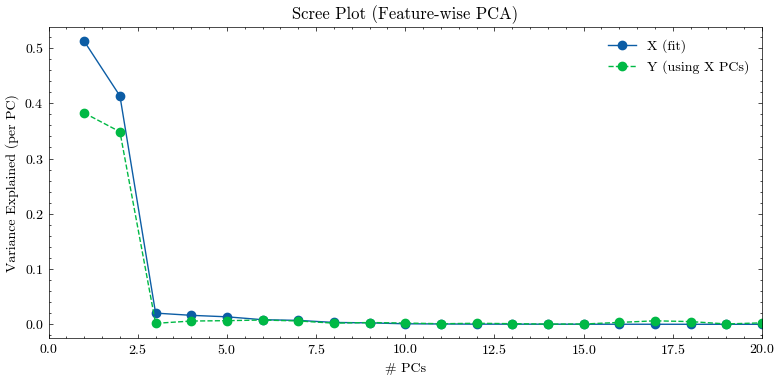

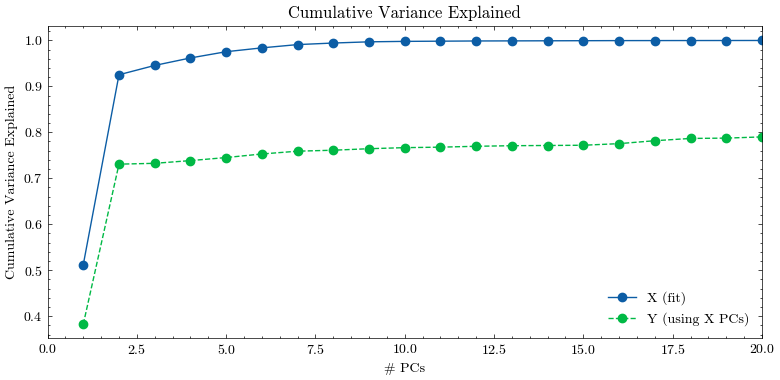

In [117]:
evr_X, cev_X, evr_Yx, cev_Yx, pca = pca_cross_variance_featurewise(test_task_0_stim, test_task_final_stim, plot=True)